In [ ]:
# ***Adding requirement for attention layer***

In [1]:
from shutil import copyfile
copyfile(src = "../input/d/sameerpimparkhede/attention/attention.py", dst = "../working/attention.py")

'../working/attention.py'

# ***importing required libraries***

In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed , Bidirectional , GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# ***Loading dataset to the notebook***

In [3]:
data=pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv")

# ***Dropping duplicate reviews and null values***

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# ***Information about datatypes and shape of the dataset***

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


# ***Dictionary for expanding the contractions***

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

# ***For removing stopwords***

# ***Function for cleaning reviews and summaries***

In [6]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    #if(num==0):
        #tokens = [w for w in newString.split() if not w in stop_words]
    tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

# ***cleaning reviews and displaying***

In [7]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))
cleaned_text[:5]  

['have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like stew than processed meat and it smells better my labrador is finicky and she appreciates this product better than most',
 'product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo',
 'this is confection that has been around few centuries it is light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is tiny mouthful of heaven not too chewy and very flavorful highly recommend this yummy treat if you are familiar with the story of lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sisters to the witch',
 'if you are looking for the secret ingredient in robitussin believe have fou

# ***cleaning summaries and displaying***

In [8]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

# ***Adding columns into the dataset***

In [9]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

# ***Dropping empty rows***

In [10]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

# ***Visualization distribution of reviews and summaries***

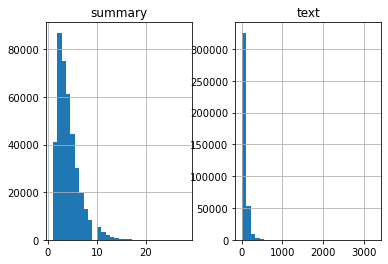

In [11]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [12]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9801405345194589


In [13]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=80):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.7075376449913914


In [14]:
max_text_len=80
max_summary_len=10

# ***getting rid of outliers***

In [15]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

# ***Adding tokens at the beginning and the end of summary***

In [16]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [17]:
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like stew than processed meat and it smells better my labrador is finicky and she appreciates this product better than most
Summary: sostok good quality dog food eostok


Review: product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo
Summary: sostok not as advertised eostok


Review: if you are looking for the secret ingredient in robitussin believe have found it got this in addition to the root beer extract ordered and made some cherry soda the flavor is very medicinal
Summary: sostok cough medicine eostok


Review: great taffy at great price there was wide assortment of yummy taffy delivery was very quick if your taffy lover this is deal
Summary: sostok great taffy eostok


Review: got wild hair for taffy and ordered thi

# ***splitting traing and test set***

In [18]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

# ***prepare a tokenizer for reviews on training data***

In [19]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

# ***calculating number of rare and common words in reviews***

In [20]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.10455283163918
Total Coverage of rare words: 0.6189153922700606


# ***defining tokenizer with most common words for reviews***

In [29]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [22]:
x_voc

22405

# ***prepare a tokenizer for summaries on training data***

In [28]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

# ***calculating number of rare and common words in summaries***

In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

ZeroDivisionError: division by zero

# ***defining tokenizer with most common words for summaries***

In [26]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

# ***checking word count of start token is equal to length of the training data***

In [29]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(247608, 247608)

# ***deleting the rows that contain only START and END tokens***

In [30]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [31]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# ***Model building, defining LSTM layers, Encoder and Decoder***

In [32]:
from keras import backend as K 
K.clear_session()

latent_dim = 150
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,recurrent_dropout=0.4))
encoder_output1, for_h1 , for_c1 , back_h1 , for_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,recurrent_dropout=0.4))
encoder_outputs, for_h2 , for_c2 , back_h2, back_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
#encoder_lstm3= Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4))
#encoder_outputs, for_h , for_c , back_h , back_c = encoder_lstm3(encoder_output2)

state_h = Concatenate()([for_h2, back_h2])
state_c = Concatenate()([for_c2, back_c2])

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h , state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 100)      2240500     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 80, 300), (N 301200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# ***monitoring the validation loss***

In [35]:
es = [ ModelCheckpoint('./MyModel_tf',monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', save_weights_only = False)]

# ***train the model on a batch size of 512 and validate it on the 10% of dataset***

In [36]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
478/478 [==============================] - ETA: 0s - loss: 2.6351
Epoch 00001: val_loss improved from inf to 2.33169, saving model to ./MyModel_tf
478/478 [==============================] - 505s 1s/step - loss: 2.6351 - val_loss: 2.3317
Epoch 2/5
478/478 [==============================] - ETA: 0s - loss: 2.2445
Epoch 00002: val_loss improved from 2.33169 to 2.13219, saving model to ./MyModel_tf
478/478 [==============================] - 502s 1s/step - loss: 2.2445 - val_loss: 2.1322
Epoch 3/5
478/478 [==============================] - ETA: 0s - loss: 2.0925
Epoch 00003: val_loss improved from 2.13219 to 2.03129, saving model to ./MyModel_tf
478/478 [==============================] - 500s 1s/step - loss: 2.0925 - val_loss: 2.0313
Epoch 4/5
478/478 [==============================] - ETA: 0s - loss: 1.9812
Epoch 00004: val_loss improved from 2.03129 to 1.92831, saving model to ./MyModel_tf
478/478 [==============================] - 502s 1s/step - loss: 1.9812 - val_loss: 1.9283


In [88]:
# serialize model to JSON
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summary.h5")
print("Saved model to disk")

Saved model to disk


# ***understanding the behavior of model over time***

In [91]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

# ***convert the index to word for summaries and reviews vocabulary***

In [169]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# ***Setting up the inference for the encoder and decoder***

In [121]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(2*latent_dim,))
decoder_state_input_c = Input(shape=(2*latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,2*latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
#print(decoder_hidden_state_input.shape)
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# ***Defining a functio for implementation of the inference process***

In [122]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

# ***converting an integer sequence to a word sequence for summaries and reviews***

In [158]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

# ***displaying some summaries generated by the model***

In [174]:
for i in range(1,50):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: this is hearty healthy and tasty chili eat it alone or use it as topping for vegetarian hot dogs or burgers it is labeled medium hot but found it to be little spicier than expected not to worry though toned it down by adding tsp of lite sour cream yum think you will enjoy this product the flavor is so good that you really do not miss the salt 
Original summary: hot stuff 
Predicted summary:  delicious


Review: wow these chocolate covered soy nuts are great am truly impressed with the high quality of the dark chocolate that truson organics uses in their product would highly recommend this healthy snack be careful you could eat the whole bag in one sitting 
Original summary: wow 
Predicted summary:  delicious


Review: we have dogs with food allergies and these are some of the only snacks we can give them they love them and the vet told us they are ok to give them so we are very happy to have found them 
Original summary: great dog treat 
Predicted summary:  my dogs love these



In [1]:
from sumeval.metrics.rouge import RougeCalculator

rouge = RougeCalculator(stopwords=True, lang="en")

def rouge_calc(preds, targets):
    rouge_1 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=1) for i in range(len(preds))]
    rouge_2 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=2) for i in range(len(preds))]
    rouge_l = [rouge.rouge_l(summary=preds[i],references=targets[i]) for i in range(len(preds))]

    return {"Rouge_1": np.array(rouge_1).mean(),
            "Rouge_2": np.array(rouge_2).mean(),
            "Rouge_L": np.array(rouge_l).mean()}

ModuleNotFoundError: No module named 'sumeval'

In [2]:
x_tokenizer.index_word

NameError: name 'x_tokenizer' is not defined